The main questions attempted to be answered in this project are

1. Are employees who only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been there longer?

2. Are younger employees resigning due to some kind of dissatisfaction? What about older employees?

In [1]:
import pandas as pd
import numpy as np
TAFE = pd.read_csv('TAFE.csv', encoding = 'ISO-8859-1')
DETE = pd.read_csv('DETE.csv', na_values = 'Not Stated') 
missing_TAFE = TAFE.isnull().sum()
missing_DETE = DETE.isnull().sum()
missing_TAFE

Record ID                                                                                                                                                          0
Institute                                                                                                                                                          0
WorkArea                                                                                                                                                           0
CESSATION YEAR                                                                                                                                                     7
Reason for ceasing employment                                                                                                                                      1
Contributing Factors. Career Move - Public Sector                                                                                                                265
Contributi

In [2]:
missing_DETE

ID                                       0
SeparationType                           0
Cease Date                              34
DETE Start Date                         73
Role Start Date                         98
Position                                 5
Classification                         367
Region                                 105
Business Unit                          696
Employment Status                        5
Career move to public sector             0
Career move to private sector            0
Interpersonal conflicts                  0
Job dissatisfaction                      0
Dissatisfaction with the department      0
Physical work environment                0
Lack of recognition                      0
Lack of job security                     0
Work location                            0
Employment conditions                    0
Maternity/family                         0
Relocation                               0
Study/Travel                             0
Ill Health 

# Observation
 -------------------
 
## TAFE Data

 1. Columns pertinent to analysis are the columns relating to current age, length of service, reason for ceasing employment and contributing factors.
 
 2. Contributing factors columns are missing 265 values that could be filled using the topic columns.
 
 3. All columns pertinent to analysis need to be renamed, they are either too long or different from DETE column names or both.
 
 4. There might possibly be a duplication of data, because the 'Record ID' column has some values with multiple counts.
 
## DETE Data
 
 1. Columns pertinent to analysis are similar to the ones for TAFE above, and columns are named appropriately.
 
 2. Contributing factors to resignation columns have 0 missing values, and have categorical data.
 
 3. The age column however has 11 missing values which could be removed if it can't be filled out using other data available.
 
 

In [3]:
# drop columns that aren't relevant to analysis

dete_new = DETE.drop(columns = list(DETE.columns[28:43]))
tafe_new = TAFE.drop(columns = list(TAFE.columns[17:66]))

<font size = 4px>Columns not needed for analysis were removed from the TAFE and DETE dataframe and assigned to the variables tafe_new and dete_new respectively.

In [4]:
# remove whitespaces and make everything lowercase; make columns with whitespaces that aren't leading or trailing, snake case

dete_new.columns = dete_new.columns.str.lower().str.strip().str.replace(' ', '_')
    
# create a dictionary for renaming the columns of the tafe_new dataframe

rename_columns = {'Record ID': 'id','CESSATION YEAR': 'cease_date','Reason for ceasing employment': 'separationtype','Gender. What is your Gender?': 'gender'
                  ,'CurrentAge. Current Age': 'age','Employment Type. Employment Type': 'employment_status','Classification. Classification': 'position',
                  'LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service','LengthofServiceCurrent. Length of Service at current workplace (in years)': 'role_service'}

# Rename the tafe_new dataframe columns using dictionary

tafe_new.rename(columns = rename_columns, inplace = True)
dete_new.separationtype.value_counts()

Age Retirement                          285
Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Voluntary Early Retirement (VER)         67
Ill Health Retirement                    61
Other                                    49
Contract Expired                         34
Termination                              15
Name: separationtype, dtype: int64

<font size = 4px>All columns in the dete_new dataframe had their names converted to lower case; and after trailing and leading whitespaces were removed, they were converted to snake case. 

Then the tefe_new dataframe columns that needed to be renamed were renamed using the dictionary rename_columns. All this was done to aid in the standardization of the column names of both dataframes, since they will be merged later on for analysis.

In [5]:
# Create copies of dataframe that contain records of employees that resigned only

filtered = dete_new.separationtype.str.contains('Resignation')
dete_updated = dete_new.loc[filtered].copy()
tafe_updated = tafe_new.loc[tafe_new.separationtype == 'Resignation'].copy()
dete_updated.separationtype.value_counts()

Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Name: separationtype, dtype: int64

In [6]:
# Cleaning cease_date and dete_start_date column for dete_updated

# Capture the year group from dates
dete_updated.cease_date = dete_updated.cease_date.str.extract(r'([0-9]{4})')
dete_updated.cease_date.value_counts()

2013    146
2012    129
2014     22
2010      2
2006      1
Name: cease_date, dtype: int64

In [7]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (10,10))
ax.set_ylim((1950,2015))
Figure = dete_updated.dete_start_date.plot(kind = 'box')

In [8]:
# replace null values for dete_start_date with role_start_date if possible
dete_updated.loc[dete_updated.dete_start_date.isnull(),'dete_start_date'] = dete_updated.loc[dete_updated.dete_start_date.isnull()].role_start_date.copy()

# Convert dete_start_date column to Int64
dete_updated.dete_start_date = dete_updated.dete_start_date.astype('Int64')

# remove rows containing outliers
removed_rows = dete_updated.loc[dete_updated.dete_start_date < 1980].index
dete_updated.drop(index = removed_rows, inplace = True)

<font size = 4px>The date columns for dete_updated and tafe_updated were analysed to see if there were any discrepancies.</font>

## dete_updated

<font size = 4px>cease_date column values were in a format of xx/xxxx (month/year); so in order to make it possible to calculate the length of time worked from start date to cease date, the year was extracted from the string and converted to an integer.

role_start_date was used to replace the one row that had a role_start_date value, and a corresponding null value in dete_start_date. 

dete_start_date column also had 10 values that showed up on a box plot as outliers, given that the column had 311 vlaues and this represented only about 3.215% of the values; I decided that the impact of removing those rows were statistically negligible.</font>

## tafe_updated

<font size = 4px>Nothing was found to be suspicious in the date column of tafe_updated, so no changes were made

In [9]:
dete_updated['institute_service'] = dete_updated['cease_date'].astype('float') - dete_updated['dete_start_date'].astype('float')
dete_updated['institute_service'] = dete_updated['institute_service'].astype('Int64')

<font size = 4px>An institute_service column was added to dete_updated, this column contains the length of service in years.

In [10]:
def update_val(val):
    if val == '-':
        val = False
    elif pd.isnull(val):
        val = np.nan
    else:
        val = True
    return val;

# apply function above to the two columns in tafe_updated related to dissatisfaction
tafe_updated[tafe_updated.columns[10:12]] = tafe_updated[tafe_updated.columns[10:12]].applymap(update_val)

<font size = 4px>The function update_val was created to change values in columns job_dissatisfaction and dissatisfaction to boolean values, the reason for this is to be able to use the df.any() method as well as standardize the analysis.

In [11]:
# Create a list of columns that are indicators of job dissatisfaction in dete_updated

dissatisfaction = dete_updated.columns[13:20]
dissatisfaction = list(dissatisfaction)
dissatisfaction.append(dete_updated.columns[25])
dissatisfaction.append(dete_updated.columns[26])

# add a column called 'dissatisfied', with values of True if any of the columns that indicate job dissatisfaction are True

tafe_updated['dissatisfied'] = tafe_updated[tafe_updated.columns[10:12]].any(axis = 1)
dete_updated['dissatisfied'] = dete_updated[dissatisfaction].any(axis = 1)

In [12]:
# Assign a copy of resulting dataframe to new variable 
tafe_final = tafe_updated.copy()
dete_final = dete_updated.copy()

<font size = 4 px>Columns in the tafe_updated and dete_updated dataframe that indicated job dissactisfaction were used to 
create a new column called 'dissatisfied' which contained boolean values, the 'dissatisfied' column contains a false value only 
if all corresponding job dissatisfaction column values in that row were false. The dete_udated and tafe_updated dataframe were 
then copied and saved to the variables dete_final and tafe_final respectively.</font>  

In [13]:
# create a function called dates to extract the years from institute_service in tafe_final dataframe
def dates(val):
    if pd.isnull(val):
        val = np.nan
    else:
        series = pd.Series(val)
        series = series.str.extract(r'([0-9][0-9]?)')
        val = series.iloc[0][0]
    return val;

# Create a function to convert values to float
def convert_values(val):
    if pd.isnull(val):
        val = np.nan
    else:
        val = float(val)
    return val;



In [14]:
# extract the years from institute_service in tafe_final dataframe
print(tafe_final.institute_service.value_counts())
tafe_final.institute_service = tafe_final.institute_service.apply(dates)
tafe_final.institute_service =tafe_final.institute_service.apply(convert_values)
tafe_final.institute_service  = tafe_final.institute_service .astype('Int64')
tafe_final.institute_service.value_counts()

Less than 1 year      73
02-Jan                64
04-Mar                63
06-May                33
20-Nov                26
10-Jul                21
More than 20 years    10
Name: institute_service, dtype: int64


1     73
2     64
4     63
20    36
6     33
10    21
Name: institute_service, dtype: int64

In [15]:
# Add a column to the tafe_final and dete_final dataframe to distinguish them

tafe_final['institute'] = 'TAFE'
dete_final['institute'] = 'DETE'

In [16]:
# rename columns in tafe_final to aid in joining dataframes

# Rename columns in the rename variable to names in the new_name variable
rename = tafe_final.columns[-8:-5]
rename = list(rename)
new_name = ['gender', 'age', 'employment_status']
rename_columns = {}
count = 0
for column in rename:
    rename_columns[rename[count]] = new_name[count]
    count+=1
tafe_final.rename(columns = rename_columns, inplace = True)

In [17]:
combined = pd.concat([tafe_final,dete_final],0, sort = True)
combined.dropna(axis = 1, thresh = 500, inplace = True)

In [18]:
#Change the institute_service column values to conform to the format below
# New: Less than 3 years at a company
# Experienced: 3-6 years at a company
# Established: 7-10 years at a company
# Veteran: 11 or more years at a company
highest_servicelength = max(combined.institute_service[combined.institute_service.notnull()])
new_format = {'New':range(0,3), 'Experienced':range(3,7), 'Established': range(7,11), 'Veteran': range(11,highest_servicelength+1)}


In [19]:
# Write a function called change_format that groups years of service according to the dictionary new_format above

def change_format(val):
    if pd.isnull(val):
        val = np.nan
    else:
        for key in new_format:
            if val in new_format[key]:
                val = key
    return val;


In [20]:
 # Apply the function change_format to the column institute_service in the combined dataframe
 # then assign it to a column called service_cat

combined['service_cat'] = combined.institute_service.apply(change_format)



In [21]:
years_service = pd.pivot_table(combined, index = combined['service_cat'])
analysis = round(years_service['dissatisfied'],2)
print(analysis)

service_cat
Established    0.52
Experienced    0.34
New            0.29
Veteran        0.47
Name: dissatisfied, dtype: float64


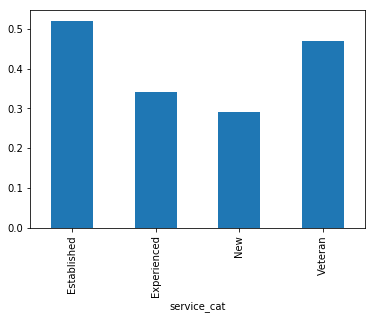

In [22]:
analysis.plot(kind = 'bar')

# Years Of Service Analysis

Based on the bar chart above, employees of both TAFE and DETE institutes combined have the least percentage of dissatisfied employees amongst employees that have been there for less than 3 years.
The highest percentage af dissatisfaction was found amongst employees that have been there for between 7-10 years. But overall there was dissatisfaction found amongst employees that have worked at the company for any length of time.

In [23]:
# Clean the age column of the combined dataframe
# inspect age column
from scipy import stats
age_institute = combined.pivot_table(index = 'age', aggfunc = stats.mode)['institute']
age_institute

C:\Users\ronal\Anaconda3\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


age
20 or younger     ([TAFE], [9])
21  25          ([TAFE], [33])
21-25            ([DETE], [29])
26  30          ([TAFE], [32])
26-30            ([DETE], [35])
31  35          ([TAFE], [32])
31-35            ([DETE], [29])
36  40          ([TAFE], [32])
36-40            ([DETE], [41])
41  45          ([TAFE], [45])
41-45            ([DETE], [48])
46  50          ([TAFE], [39])
46-50            ([DETE], [42])
51-55            ([TAFE], [39])
56 or older      ([TAFE], [29])
56-60            ([DETE], [23])
61 or older      ([DETE], [18])
Name: institute, dtype: object

As seen in the above output, the age column from the tafe dataframe has a different format from dete dataframe, even though the values are the same. The next stage is to convert the unknown character to '-', in order to standardize the data.

In [24]:
# Find the unknown chracter in the age column of the tafe_final dataframe
unknown_character = tafe_final.age.value_counts().index[0]
unknown_character = unknown_character[3]
unknown_character

'\x96'

In [25]:
# Replace unknown character with '-' in the age column of combined
combined.age = combined.age.str.replace(' ' + unknown_character + ' ','-')
combined.age.value_counts()

41-45            93
46-50            81
36-40            73
51-55            69
26-30            67
21-25            62
31-35            61
56 or older      29
56-60            23
61 or older      18
20 or younger    10
Name: age, dtype: int64

The age column looks is divided into several age group, which gives us a good platform for explicit analysis. However there seems to be a conflict with one institution having an age group of 56-60 and 61 or older, and the other combining the two age groups into 56 or older. 

For the sake of easy interpretation, the two will be combined combined in the combine dataframe as well.

In [26]:
# Create a function that'll modify the age column

age_range = combined.age.value_counts().index
age_list = []
for age in age_range[8:10]:
    age_list.append(age)
new_age = age_range[7]

def age_change(age):
    if age in age_list:
        age = new_age
    return age;


In [27]:
# Apply function to column
# inspect age column to ensure ages were changed
combined.age = combined.age.apply(age_change)
combined.age.value_counts()

41-45            93
46-50            81
36-40            73
56 or older      70
51-55            69
26-30            67
21-25            62
31-35            61
20 or younger    10
Name: age, dtype: int64

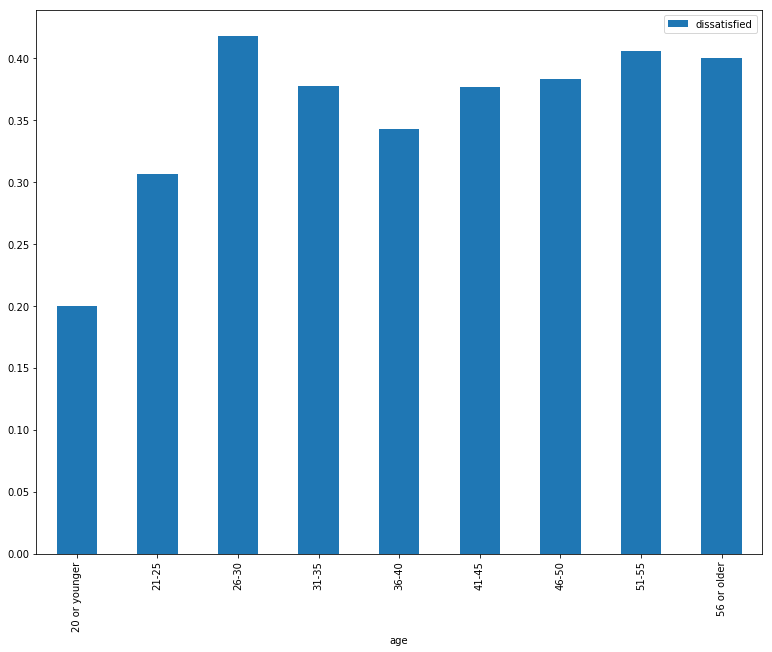

In [36]:
# Create a pivot table to analyse the age column
Analysis = pd.pivot_table(combined, index = 'age', values = 'dissatisfied')
Analysis.plot(kind = 'bar', figsize = (13,10))

## Age Findings

- The group of 18 - 20 year olds has the lowest percentage of dissatisfied individuals.
- There is a sharp rise in percentage of dissatisfied individuals from the age range of 18-20 year olds to the age range of 26 - 30 year olds.
- The group of 26 - 30 year olds have the highest percentage of dissatisfied individuals, and defines the peak of the bar chart above.
- The percentage of dissatisfied individuals gradually declines from the age group of 26 - 30 year olds until the age range of 36 - 40 year olds, at which point it steadily rises until it hits a point close to the peak at the age range of 51 - 55 year olds.
- 41 - 45 year olds and 46 - 50 year olds possess similar levels of dissatisfaction.
- 51 - 55 year olds and 56 or older possess similar levels of dissatisfaction.